# Телеком

Оператор связи хочет прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.feature_selection import SelectPercentile, chi2

## Загрузка и первичный анализ данных

Загрузим и посмотрим на данные

In [3]:
dt_contract = pd.read_csv('contract.csv')
dt_personal = pd.read_csv('personal.csv')
dt_internet = pd.read_csv('internet.csv')
dt_phone = pd.read_csv('phone.csv')

In [5]:
dt_contract = pd.read_csv('/datasets/final_provider/contract.csv')
dt_internet = pd.read_csv('/datasets/final_provider/internet.csv')
dt_personal = pd.read_csv('/datasets/final_provider/personal.csv')
dt_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
dt_list = [dt_contract, dt_personal, dt_internet, dt_phone]
name_list = ['Иинформация о договоре', 'Персональные данные клиента', 'Информация об интернет-услугах', 'Информация об услугах телефонии']

for dt, name in zip(dt_list, name_list):
    print(name)
    display(dt.head())
    dt.info()
    print()
    print('Количество дубликатов:', dt.duplicated().sum())
    print()
    print('Пропуски:')
    display(dt.isna().sum())
    print('**********************************')
    print()

Иинформация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Количество дубликатов: 0

Пропуски:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

**********************************

Персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Количество дубликатов: 0

Пропуски:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

**********************************

Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Количество дубликатов: 0

Пропуски:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

**********************************

Информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Количество дубликатов: 0

Пропуски:


customerID       0
MultipleLines    0
dtype: int64

**********************************



В данных нет пропусков и дубликатов.  
Таблица информация о договоре содержит признаки 'BeginDate' и 'EndDate' - даты заключения и окончания договора.  
Целевой признак - факт оттока клиента, можно получить из признака EndDate, где значение 'No' - это выходит договор действовал на дату выгрузки данных.  
Признак 'MonthlyCharges' - ежемесячные платежи клиента, 'TotalCharges' - похоже суммарные платежи клиента за весь период осбслуживания. В признаке 'TotalCharges' данные представлены строками и некоторые значения не конвертируются в тип float т.к. заполнены пустой строкой. Посмотрим что это за договора.

In [7]:
dt_contract[dt_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Это новые договора, заключены в день выгрузки и клиенты еще ни разу не платили. Их можно будет удалить или заполнить значения 0.

Посмотрим на распределение значений в признаке 'EndDate'

In [8]:
dt_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Удивительно, что клиенты уходили примерно в равных количествах и в одни и те же даты. И было это всего 4 раза за весь период, причем подряд, с октября 2019 по январь 2020. Не похоже на естественное поведение клиентов.

Признаки 'Type', 'PaperlessBilling', 'PaymentMethod' - категориальные, посмотрим на распределение их значений.

Type


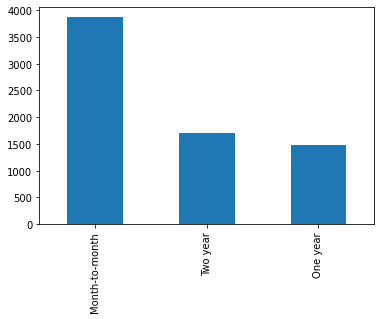

PaperlessBilling


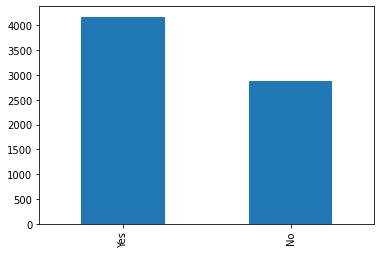

PaymentMethod


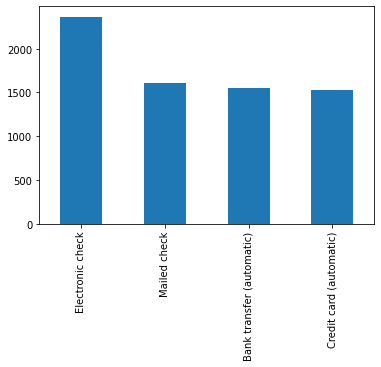

In [9]:
for feature in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print(feature)
    dt_contract[feature].value_counts().plot(kind='bar')
    plt.show()

Скрытых дубликатов, аномалий не наблюдается. Количество уникальных значений небольшое, можно будет использовать технику One-Hot Encoding для проеобразования данных - таблица увеличится незначительно.
Аналогично в остальных таблицах. 'Персональные данные клиента', 'Информация об интернет-услугах', 'Информация об услугах телефонии' - все признаки бинарные. 'InternetService' в 'Информация об интернет-услугах' имеет 2 значения: Fiber optic и DSL.

###  Список уточняющих вопросов

1. Целевой признак определяем по активным контрактам на дату выгрузки 01.02.2020 по признаку 'EndDate'?
2. Признак 'EndDate', почему записи свидетельствуют, что клиенты уходили примерно в равных количествах, в одни и те же даты, было это всего 4 раза за весь период, причем подряд с октября 2019 по январь 2020? Не похоже на естественное поведение клиентов.
3. У нас задача классификации, уйдет/не уйдет. Какую метрику качества будем использовать? F1-мера? AUC-ROC?
4. С точки зрения бизнеса телеком вероятно важно определить склонных к оттоку и удержать их и в то же время не перекупить у себя же пользователей ложно причисленным к таким и тем самым снизить свою прибыль. Нужно ли отдельно достичь каких то значений мер точности или полноты?
5. Каких значений метрики качества надо достичь?
6. Есть ли ограничения по применяемым алгоритмам для обученяи моделей?
7. В выборке клиенты пользующиеся разными услугами, разными технологиями. Модель должна быть универсальной? Или ориентированной на какие-то определенные категории клиентов?
8. Что за признаки в таблице 'personal' - Partner, Dependents?

### Примерный план решения задачи.

1. Подготовка данных.
 - Предобработка, приведение типов данных. Объединение датасетов, заполнение/удаление пропусков. Определение целевого признака. 
2. Исследовательский анализ данных.
 - Выявление зависимостей и аномалий в данных. Проверка гипотез. Избавление от выбросов и избыточных данных.
3. Подготовка данных для обучения моделей
 - Выделение целевого признака. Стандартизация, анализ/устранение дисбаланса, добавление/удаление признаков. Разделение данных на train и test.
4. Настройка, обучение и тестирование моделей.
 - Подбор гиперпараметров и моделей для достижения заданного значения метрики. Тестирование лучших моделей на тестовой выборке.
5. Заключение

## Подготовка данных

Добавим в dt_contract столбец с целевым признаком, назовем его 'Exited'

In [10]:
dt_contract['Exited'] = np.where(dt_contract['EndDate'] == 'No', 0, 1)
display(dt_contract.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


Добавим в таблицу dt_phone признак 'PhoneService', что это пользователь сервиса телефонии.

In [11]:
dt_phone['PhoneService'] = 'Yes'
dt_phone.info()
display(dt_phone.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
 2   PhoneService   6361 non-null   object
dtypes: object(3)
memory usage: 149.2+ KB


,customerID,MultipleLines,PhoneService
0,5575-GNVDE,No,Yes
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,Yes


Объединим все данные в один датафрейм

In [12]:
dt_full = dt_contract.merge(dt_personal, on='customerID', how='left').merge(
                            dt_phone, on='customerID', how='left').merge(
                            dt_internet, on='customerID', how='left')
dt_full.info()
dt_full.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Exited            7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     6361 non-null   object 
 14  PhoneService      6361 non-null   object 
 15  InternetService   5517 non-null   object 
 16  OnlineSecurity    5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,gender,...,Dependents,MultipleLines,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,No,NaN,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,Male,...,No,No,Yes,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,Yes,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,NaN,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Yes,Fiber optic,No,No,No,No,No,No


Удалим записи с новыми контрактами, заключенными в день выгрузки и где клиенты еще не пользовались услугами и ни разу не платили.

In [13]:
dt_full = dt_full.loc[dt_full['BeginDate'] != '2020-02-01']
dt_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   object 
 8   Exited            7032 non-null   int64  
 9   gender            7032 non-null   object 
 10  SeniorCitizen     7032 non-null   int64  
 11  Partner           7032 non-null   object 
 12  Dependents        7032 non-null   object 
 13  MultipleLines     6352 non-null   object 
 14  PhoneService      6352 non-null   object 
 15  InternetService   5512 non-null   object 
 16  OnlineSecurity    5512 non-null   object 


Посмотрим на распределение дат ухода клиентов.

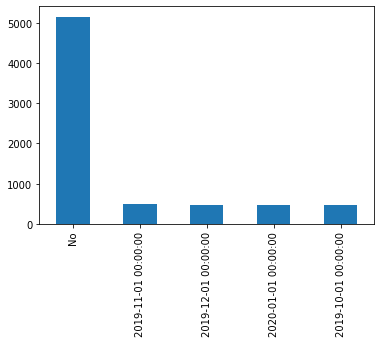

In [14]:
dt_full['EndDate'].value_counts().plot(kind='bar')
plt.show()

Выгрузка данных выполнена на 01.02.2020. Отток начался четыре месяца назад. Возможно появился какой-то новый конкурент и клиенты стали уходить. Видимо раньше у нашей компании не было серьезной конкуренции. Использование признаков-дат в такой ситуации приведет к ненужному влиянию их на целевые метрики во время обучения и снизит эффективность работы итоговых моделей при использовании их бизнесом в дальнейшем. Но из 'BeginDate' и 'EndDate' можно получить "время жизни" клиента в компании, что вероятно будет полезной информацией для обучения будущих моделей.

Добавим новый столбец 'TenureDay' - количество дней действия контракта клиента до момента расторжения. Для тех у кого контаркт действовал на дату выгрузки примем за конечную дату '2020-02-01'

In [15]:
dt_full['BeginDate'] = dt_full['BeginDate'].astype('datetime64')
dt_full['EndDate'] = dt_full['EndDate'].replace(to_replace=['No'], value=['2020-02-01']).astype('datetime64')

dt_full['TenureDay'] = (dt_full['EndDate'] - dt_full['BeginDate']).dt.days


dt_full.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,gender,...,MultipleLines,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TenureDay
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,NaN,NaN,DSL,No,Yes,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,Male,...,No,Yes,DSL,Yes,No,Yes,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,Yes,DSL,Yes,Yes,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,NaN,NaN,DSL,Yes,No,Yes,Yes,No,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Yes,Fiber optic,No,No,No,No,No,No,61
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5,1,Female,...,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,245
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0,Male,...,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.9,0,Female,...,NaN,NaN,DSL,Yes,No,No,No,No,No,306
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,Female,...,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,853
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,0,Male,...,No,Yes,DSL,Yes,Yes,No,No,No,No,1888


Столбцы 'BeginDate' и 'EndDate' удалим.

In [16]:
dt_full = dt_full.drop(['BeginDate','EndDate'], axis=1)
dt_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   object 
 6   Exited            7032 non-null   int64  
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  MultipleLines     6352 non-null   object 
 12  PhoneService      6352 non-null   object 
 13  InternetService   5512 non-null   object 
 14  OnlineSecurity    5512 non-null   object 
 15  OnlineBackup      5512 non-null   object 
 16  DeviceProtection  5512 non-null   object 


Посмотрим на количество образовавшихся пропусков

In [17]:
dt_full.isna().sum()

customerID             0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Exited                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        680
PhoneService         680
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
TenureDay              0
dtype: int64

Вероятно пропуски означают, что клиенты этими услугами не пользуются. Заполним их значением 'No'. Для пропусков в признаке 'InternetService' введем третью категрию 'No internet'

In [18]:
dt_full['InternetService'] = dt_full['InternetService'].fillna('No internet')
dt_full = dt_full.fillna('No')

print('Количество пропусков: ', dt_full.isna().sum().sum())
dt_full.head()

Количество пропусков:  0


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,gender,SeniorCitizen,Partner,...,MultipleLines,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TenureDay
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,...,No,No,DSL,No,Yes,No,No,No,No,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.5,0,Male,0,No,...,No,Yes,DSL,Yes,No,Yes,No,No,No,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,...,No,Yes,DSL,Yes,Yes,No,No,No,No,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,...,No,No,DSL,Yes,No,Yes,Yes,No,No,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,...,No,Yes,Fiber optic,No,No,No,No,No,No,61


Приведем типы для категориальных признаков к соответствующему формату. И столбец 'TotalCharges' из строкового в float.

In [19]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner',
                'Dependents', 'MultipleLines', 'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for ct in cat_features:
    dt_full[ct] = dt_full[ct].astype('category')
    
dt_full['TotalCharges'] = dt_full['TotalCharges'].astype('float64')
    
dt_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   Type              7032 non-null   category
 2   PaperlessBilling  7032 non-null   category
 3   PaymentMethod     7032 non-null   category
 4   MonthlyCharges    7032 non-null   float64 
 5   TotalCharges      7032 non-null   float64 
 6   Exited            7032 non-null   int64   
 7   gender            7032 non-null   category
 8   SeniorCitizen     7032 non-null   category
 9   Partner           7032 non-null   category
 10  Dependents        7032 non-null   category
 11  MultipleLines     7032 non-null   category
 12  PhoneService      7032 non-null   category
 13  InternetService   7032 non-null   category
 14  OnlineSecurity    7032 non-null   category
 15  OnlineBackup      7032 non-null   category
 16  DeviceProtection  7032 n

## Исследовательский анализ данных.

Попробуем выяснить какие клиенты более склонны к оттоку. Посмотрим на рапсределение ежемесячных трат по всем клиентам и по ушедшим

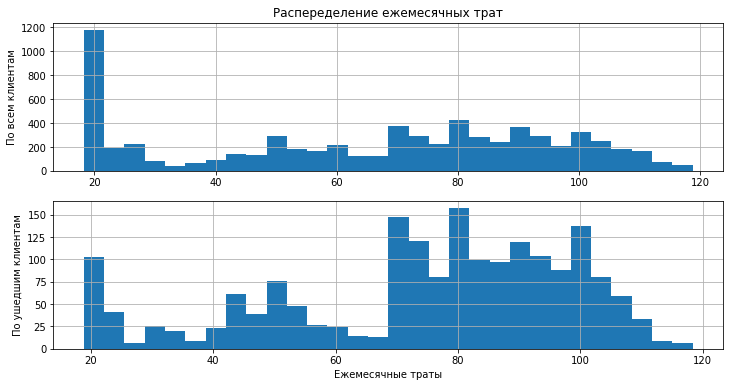

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

dt_full.MonthlyCharges.hist(ax = axes[0], bins=30)
dt_full[dt_full['Exited'] == 1].MonthlyCharges.hist(ax = axes[1], bins=30)

axes[0].set_title('Распеределение ежемесячных трат')
axes[0].set_ylabel('По всем клиентам')
axes[1].set_ylabel('По ушедшим клиентам')
axes[-1].set_xlabel('Ежемесячные траты')
plt.show()

В распределении ежемесячных трат присутствуют признаки бимодальности, видимо это связано с разностью в категориях и стоимости потребляемых услуг. Наблюдается значительный отток высокодоходных клиентов с тратами выше 70. Можно попробовать посмотреть на распределение трат клиентов в разрезе потребляемых сервисов.

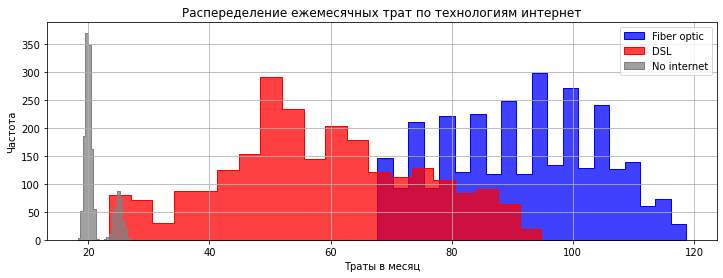

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Распеределение ежемесячных трат по технологиям интернет')
ax.set_xlabel('Траты в месяц')
ax.set_ylabel('Частота')
ax.grid()
fig.set_size_inches(12, 4)

for service, color in zip(dt_full['InternetService'].value_counts().index, ['blue', 'red', 'gray']):
    snsplot = sns.histplot(dt_full[dt_full['InternetService'] == service]['MonthlyCharges'], 
                          label=service, color=color, bins=20, element='step')
    fig = snsplot.get_figure()
    ax.legend()


Распределение похоже на предущий график. Больше всех тратят пользователи сервиса интернет по оптоволоконной линии. Это и понятно, технология более современная, скорости выше, доступны различные высокотехнологичные услуги. В этой же категории наблюдается и наибольший отток. Вероятно также нужно рекомендовать проанализировать предложения конкурентов в этом сегменте и выяснить куда и на какие предложения происходит миграция. Вохможно причина не только в стоимости услуг и одними скидками их не удержать. 

Посмотрим на доли этих клиентов в доходах и оттоке

,Технология,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,DSL,140340.65,2416,58.088017,0.307994,459,0.245586
1,Fiber optic,283284.40,3096,91.500129,0.621700,1297,0.693954
2,No internet,32035.95,1520,21.076283,0.070307,113,0.060460


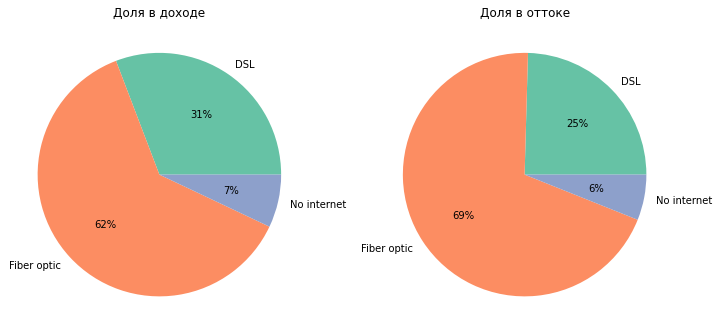

In [22]:
t1 = dt_full.pivot_table(index = 'InternetService', 
                              values = 'MonthlyCharges',
                              aggfunc = ['sum', 'count', 'mean']).reset_index()
t1.columns = ['Технология', 'Доход в мес.', 'Кол.клиентов', 'Средний доход в мес.']
t1['Доля в доходе'] = t1['Доход в мес.'] / dt_full['MonthlyCharges'].sum()

t2 = dt_full[dt_full['Exited'] == 1].pivot_table(index = 'InternetService',
                                                 values = 'Exited',
                                                 aggfunc = 'count').reset_index()
t2.columns = ['Технология', 'Ушло клиентов']
t2['Доля в оттоке'] = t2['Ушло клиентов'] / t2['Ушло клиентов'].sum()

tab = t1.merge(t2, on='Технология', how='left')

display(tab)

plt.figure(figsize=(12, 6))

plt.subplot (1, 2, 1)
colors = sns.color_palette('Set2')
plt.pie(tab['Доля в доходе'], labels = tab['Технология'], colors = colors, autopct='%.0f%%')
plt.title('Доля в доходе')

plt.subplot (1, 2, 2)

plt.pie(tab['Доля в оттоке'], labels = tab['Технология'], colors = colors, autopct='%.0f%%')
plt.title('Доля в оттоке')
plt.show()

Все верно, клиенты оптоволокна (самые высокодоходные) уходят. По технологии DSL и пользователям чистой телефонии ситуация лучше, видимо там у клиентов запросы ниже, платят они меньше, возможно там технически сложнее сменить поставщика услуг. Вероятно это более давние клиенты. Посмотрим на распределение времени жизни клиентов в компании.

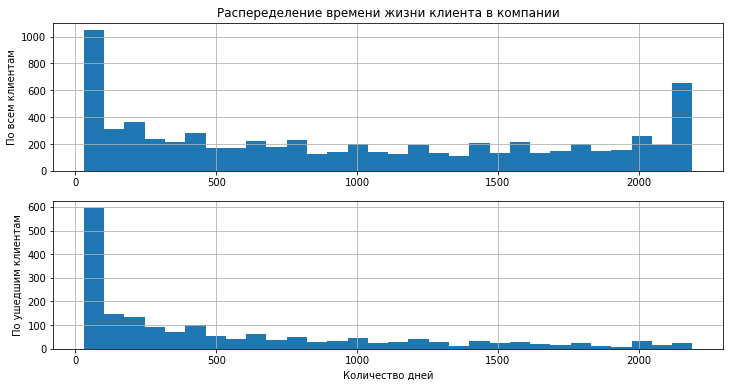

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

dt_full.TenureDay.hist(ax = axes[0], bins=30)
dt_full[dt_full['Exited'] == 1].TenureDay.hist(ax = axes[1], bins=30)

axes[0].set_title('Распеределение времени жизни клиента в компании')
axes[0].set_ylabel('По всем клиентам')
axes[1].set_ylabel('По ушедшим клиентам')
axes[-1].set_xlabel('Количество дней')
plt.show()

Отчетливо просматривается снижение оттока с ростом срока обслуживания клиентов. При этом в компании достаточно много давних и похоже все еще лояльных клиентов.

Посмотрим на распределение долей в доходах и оттоке по остальным признакам.

In [24]:
# Функция отрисовки круговой диаграммы
def draw_pie(data1, labels1, title1, data2, labels2, title2):
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette('Set2')
    
    plt.subplot (1, 2, 1)
    plt.pie(data1, labels = labels1, colors = colors, autopct='%.0f%%')
    plt.title(title1)

    plt.subplot (1, 2, 2)
    plt.pie(data2, labels = labels2, colors = colors, autopct='%.0f%%')
    plt.title(title2)
    
    plt.show()

In [25]:
# Функция анализа признаков по доходности и оттоку
def revenue_chern_analysis(data, feature):

    t1 = data.pivot_table(index = feature, 
                              values = 'MonthlyCharges',
                              aggfunc = ['sum', 'count', 'mean']).reset_index()
    t1.columns = [feature, 'Доход в мес.', 'Кол.клиентов', 'Средний доход в мес.']
    t1['Доля в доходе'] = t1['Доход в мес.'] / data['MonthlyCharges'].sum()

    t2 = data[data['Exited'] == 1].pivot_table(index = feature,
                                                 values = 'Exited',
                                                 aggfunc = 'count').reset_index()
    t2.columns = [feature, 'Ушло клиентов']
    t2['Доля в оттоке'] = t2['Ушло клиентов'] / t2['Ушло клиентов'].sum()

    tab = t1.merge(t2, on=feature, how='left')

    display(tab)

    draw_pie(tab['Доля в доходе'], tab[feature], feature + ', доли в доходе',
             tab['Доля в оттоке'], tab[feature], feature + ', доли в оттоке')

,Type,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,Month-to-month,257294.15,3875,66.398490,0.564661,1655,0.885500
1,One year,95796.90,1472,65.079416,0.210237,166,0.088818
2,Two year,102569.95,1685,60.872374,0.225101,48,0.025682


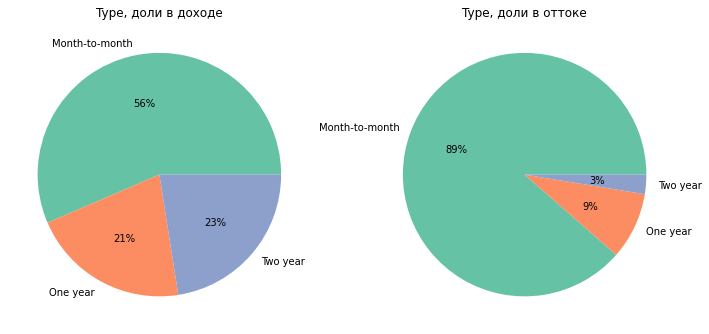

,PaperlessBilling,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,149002.35,2864,52.025960,0.327003,469,0.250936
1,Yes,306658.65,4168,73.574532,0.672997,1400,0.749064


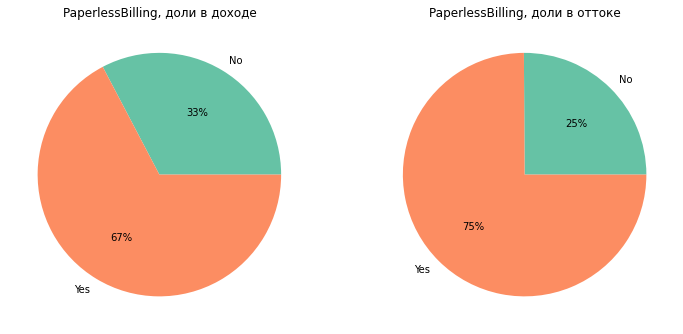

,PaymentMethod,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,Bank transfer (automatic),103631.0,1542,67.205577,0.227430,258,0.138042
1,Credit card (automatic),101175.8,1521,66.519264,0.222042,232,0.124131
2,Electronic check,180345.0,2365,76.255814,0.395788,1071,0.573034
3,Mailed check,70509.2,1604,43.958354,0.154740,308,0.164794


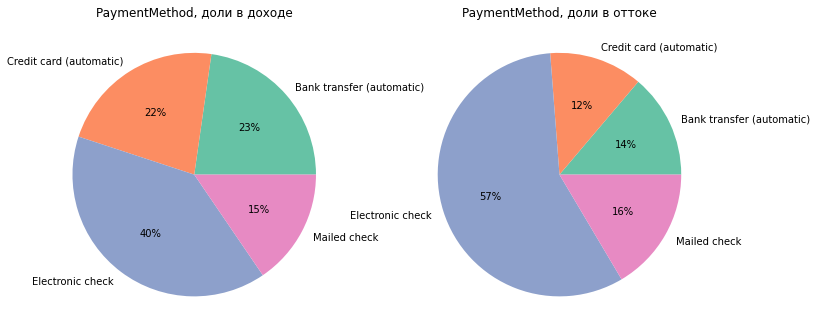

,gender,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,Female,227149.6,3483,65.216652,0.498506,939,0.502408
1,Male,228511.4,3549,64.387546,0.501494,930,0.497592


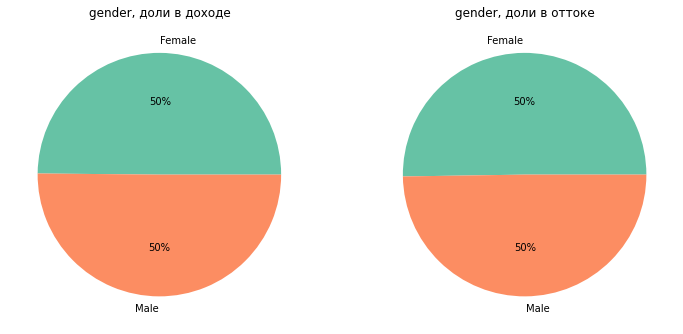

,SeniorCitizen,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,0,364506.15,5890,61.885594,0.79995,1393,0.745318
1,1,91154.85,1142,79.820359,0.20005,476,0.254682


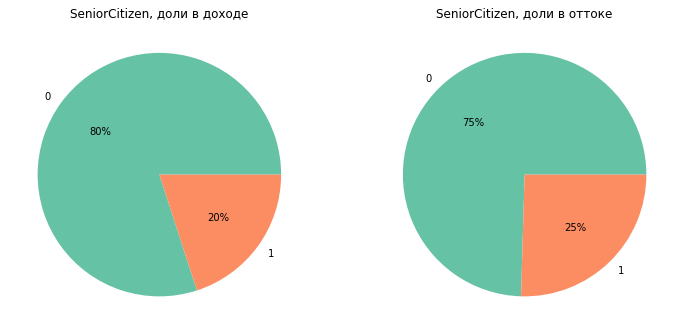

,Partner,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,225459.6,3639,61.956472,0.494797,1200,0.642055
1,Yes,230201.4,3393,67.845977,0.505203,669,0.357945


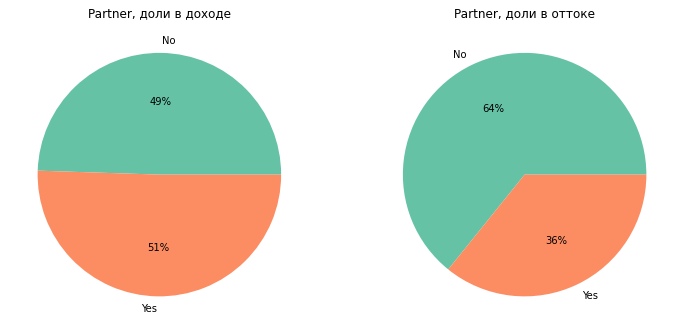

,Dependents,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,330524.85,4933,67.002808,0.725374,1543,0.825575
1,Yes,125136.15,2099,59.617032,0.274626,326,0.174425


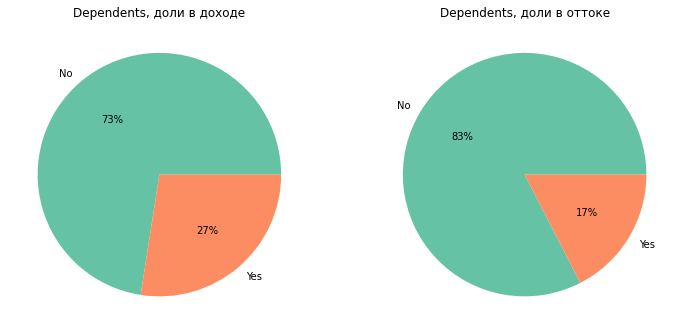

,MultipleLines,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,212115.5,4065,52.180935,0.465512,1019,0.545211
1,Yes,243545.5,2967,82.084766,0.534488,850,0.454789


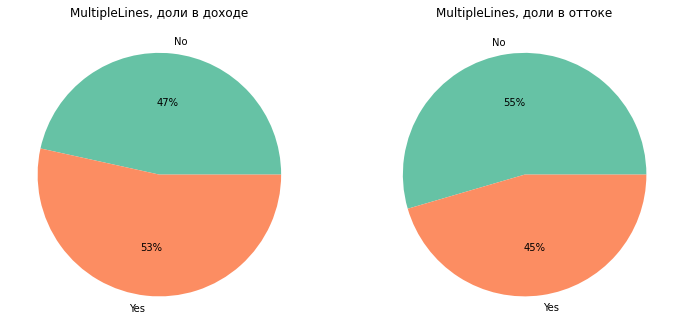

,PhoneService,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,28554.9,680,41.992500,0.062667,170,0.090958
1,Yes,427106.1,6352,67.239625,0.937333,1699,0.909042


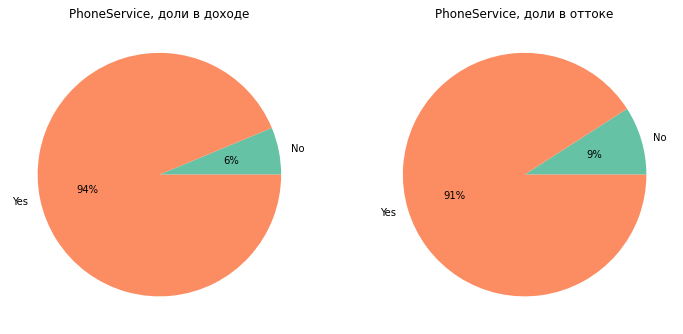

,OnlineSecurity,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,296736.95,5017,59.146293,0.651223,1574,0.842162
1,Yes,158924.05,2015,78.870496,0.348777,295,0.157838


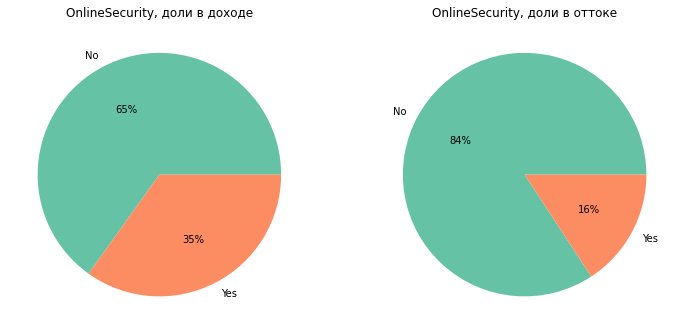

,OnlineBackup,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,254127.95,4607,55.161265,0.557713,1346,0.720171
1,Yes,201533.05,2425,83.106412,0.442287,523,0.279829


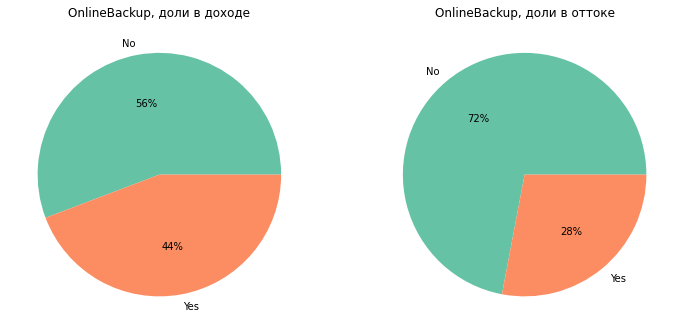

,DeviceProtection,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,250484.3,4614,54.287885,0.549716,1324,0.7084
1,Yes,205176.7,2418,84.853888,0.450284,545,0.2916


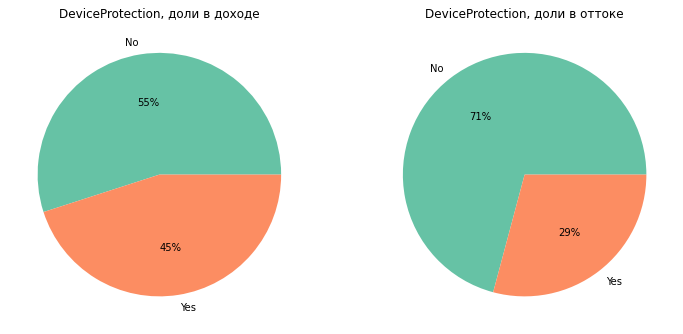

,TechSupport,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,290994.65,4992,58.292198,0.638621,1559,0.834136
1,Yes,164666.35,2040,80.718799,0.361379,310,0.165864


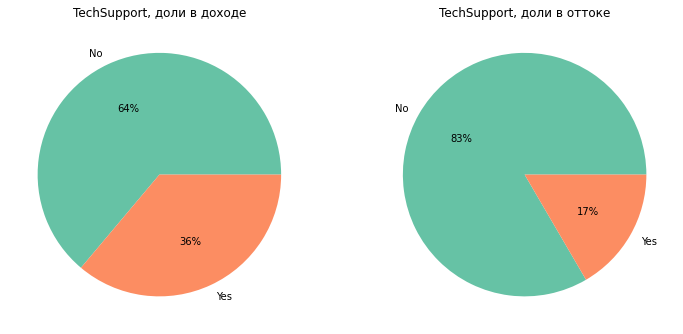

,StreamingTV,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,215713.45,4329,49.829857,0.473408,1055,0.564473
1,Yes,239947.55,2703,88.770829,0.526592,814,0.435527


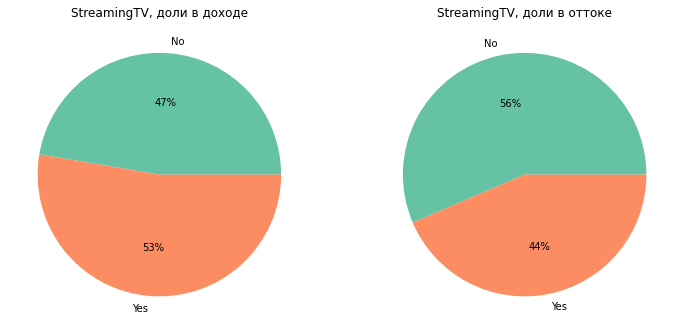

,StreamingMovies,Доход в мес.,Кол.клиентов,Средний доход в мес.,Доля в доходе,Ушло клиентов,Доля в оттоке
0,No,214026.2,4301,49.761962,0.469705,1051,0.562333
1,Yes,241634.8,2731,88.478506,0.530295,818,0.437667


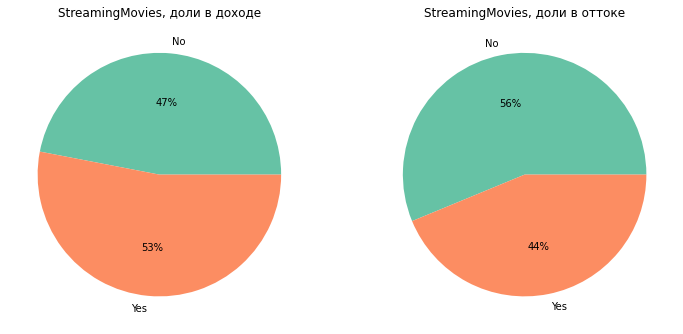

In [26]:
features_for_pie = cat_features.copy()
features_for_pie.remove('InternetService')
for feature in features_for_pie:
    revenue_chern_analysis(dt_full, feature)
    print()

По типу оплаты - около 90% ушедших клиентов с ежемесячной оплатой. Таже вероятно чаще уходят продвинутые клиенты: платят удаленно и по безналичному рассчету. Менее склонны к оттоку клиенты использующие автоматическую оплату услуг, видимо они реже контролируют свои расходы. У пенсионеров средние платежи в месяц выше, при этом причины оттока могут быть и естественными. Средний чек чуть выше у клиентов имеющих супруга(у), но меньше у клиентов с детьми. Видимо клиенты с детьми более взвешенно подходят к выбору пакетов услуг и соответственно доля оттока среди них несколько ниже. А вот различий в поведении по гендерному признаку не наблюдается. От 54% до 86% ушедших клиентов не пользовались дополнительными услугами. Они же рприносли до 65% доходов в месяц. Исключение сервисы StreamingTV и StreamingMovies - доля в доходах от их пользователей больше половины. 

Посмотрим баланс целевого признака

0    0.734215
1    0.265785
Name: Exited, dtype: float64


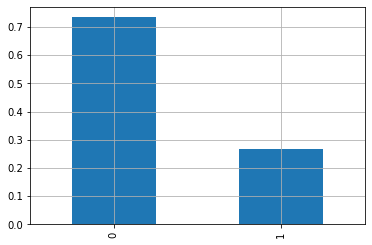

In [27]:
class_frequency = dt_full['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.grid()
plt.show()

Целевой признак несбалансирован. Нужно это учесть при обучении моделей. 

Предыдущий анализ показал, что вероятно имеются как сильные, так и слабые зависимости между признаками и их влиянием на целевой признак. Для численных признаков можно построить матрицу корреляции. Для категориальных этот вариант не походит, попробуем воспользоваться статистическим анализом гипотез.  
Нулевая гипотеза: Признак и таргет не имеют ассоциации или корреляции между ними.  
Альтернативная гипотеза: Признак и таргет связаны друг с другом и имеется корреляция между ними.

Проверим нашу гипотезу для категориальных признаков.

In [28]:
impact_churn = pd.DataFrame(columns=['Признак', 'p-value', 'Связь отсутствует'])
display(impact_churn)

,Признак,p-value,Связь отсутствует


In [29]:
alpha = 0.05

for feature in cat_features:
    results = chi2_contingency(pd.crosstab(dt_full['Exited'], dt_full[feature]))
    p = results[1]
    
    if p <= alpha: 
        answer = 'Отвергаем'
    else: 
        answer = 'Принимаем'
    
    row = {'Признак' : feature,
            'p-value' : p,
            'Связь отсутствует' : answer}
    
    impact_churn = impact_churn.append(row, ignore_index=True)
    
display(impact_churn.sort_values('Связь отсутствует', ascending=False))

,Признак,p-value,Связь отсутствует
3,gender,4.904885e-01,Принимаем
8,PhoneService,3.499240e-01,Принимаем
0,Type,7.326182e-257,Отвергаем
1,PaperlessBilling,8.236203e-58,Отвергаем
2,PaymentMethod,1.426310e-139,Отвергаем
4,SeniorCitizen,2.479256e-36,Отвергаем
5,Partner,3.973798e-36,Отвергаем
6,Dependents,2.019659e-42,Отвергаем
7,MultipleLines,8.694083e-04,Отвергаем
9,InternetService,5.831199e-159,Отвергаем


Вероятность того, что признаки 'gender' и 'PhoneService' не имеют корреляции с цлевым признаком и влияния на него, относительно высока. Принимаем нулевую гипотезу для этих признаков. Для остальных - отвергаем нулевую гипотезу.

Построим матрицу корреляции числовых признаков.

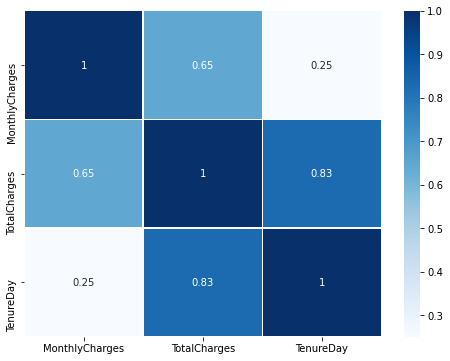

In [28]:
corr = dt_full[['MonthlyCharges', 'TotalCharges', 'TenureDay']].corr().abs().round(2)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, yticklabels=corr.columns, annot=True, cmap="Blues", linewidths=.5, ax=ax)
plt.show()

Видим высокую корреляцию между Длительностью обслуживания клиента и Общей потраченной суммой денег на услуги. Это логично. Также наблюдается средняя корреляция между Суммами потраченными за месяц и Общей потраченной суммой, что также объяснимо.

## Подготовка данных для обучения моделей

Удалим ненужный признак customerID, также удалим признаки 'gender' и 'PhoneService', мы определили, что они не влияют на факт ухода клиента. Кроме того откажемся от признака 'TotalCharges'.

In [30]:
dt_full = dt_full.drop(['customerID', 'TotalCharges', 'gender', 'PhoneService'], axis = 1)
dt_full.head(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Exited,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TenureDay
0,Month-to-month,Yes,Electronic check,29.85,0,0,Yes,No,No,DSL,No,Yes,No,No,No,No,31
1,One year,No,Mailed check,56.95,0,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1036


В основном алгоритмы машинного обучения ожидают числовые входные данные, поэтому закодируем наши категориальные данные техникой OHE. Данные в основномм бинарные, количество столбцов увеличится незначительно.

In [31]:
cat_features.remove('gender')
cat_features.remove('PhoneService')
dt_ohe = pd.get_dummies(dt_full, columns = cat_features, drop_first = True)
dt_ohe.head()

,MonthlyCharges,Exited,TenureDay,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,...,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No internet,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,29.85,0,31,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,56.95,0,1036,1,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
2,53.85,1,61,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
3,42.30,0,1371,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,70.70,1,61,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [32]:
dt_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   Exited                                 7032 non-null   int64  
 2   TenureDay                              7032 non-null   int64  
 3   Type_One year                          7032 non-null   uint8  
 4   Type_Two year                          7032 non-null   uint8  
 5   PaperlessBilling_Yes                   7032 non-null   uint8  
 6   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 7   PaymentMethod_Electronic check         7032 non-null   uint8  
 8   PaymentMethod_Mailed check             7032 non-null   uint8  
 9   SeniorCitizen_1                        7032 non-null   uint8  
 10  Partner_Yes                            7032 non-null   uint8  
 11  Depe

Разделим данные в выборке на обучающие и тестовые.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    dt_ohe.drop('Exited', axis=1), dt_ohe.Exited, test_size=0.25, random_state=12345)

print(X_train.shape)
print(X_test.shape)

(5274, 20)
(1758, 20)


Помня о дисбалансе в целевом признаке, создадим функцию для его устранения в выборках.

In [34]:
# Функция принимает на вход выборки признаков и таргета 
# и переменную up_down - признак:
# 'up' - upsampling, 'down' - downsampling
# Возвращает сблансированные выборки

def resample_class(features, target, up_down):
   
    name_target = target.name
    X = pd.concat([features, target], axis=1)
    class_0 = X[X[name_target]==0]
    class_1 = X[X[name_target]==1]
    
    if up_down == 'up':
        class_1_upsampled = resample(class_1,
                              replace=True,
                              n_samples=len(class_0),
                              random_state=12345) 
        newsample = pd.concat([class_0, class_1_upsampled])
    
    else: 
        class_0_downsampled = resample(class_0,
                                replace = False, 
                                n_samples = len(class_1), 
                                random_state = 12345) 
        newsample = pd.concat([class_0_downsampled, class_1])
           
    y_train = newsample[name_target]
    X_train = newsample.drop(name_target, axis=1)
    X_train, y_train = shuffle(X_train, y_train, random_state=12345)
    
    return X_train, y_train

In [35]:
y_train.value_counts()

0    3870
1    1404
Name: Exited, dtype: int64

Единиц в обучающем таргете всего 1404. Устранение дисбаланса downsampling-ом вероятно приведет к сокращению важной информации и может приветси к недообучению. Создадим дополнительную обучающую выборку upsampling-ом. И посмотрим как эти данные повлияют на обучение моделей.

0    0.5
1    0.5
Name: Exited, dtype: float64


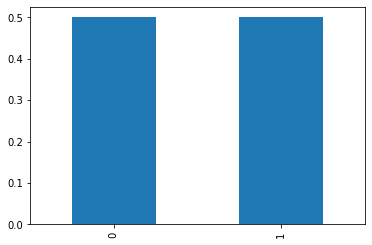

In [36]:
X_train_upsampled, y_train_upsampled = resample_class(X_train, y_train, 'up')

class_frequency = y_train_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

In [37]:
print(y_train.value_counts())
print(y_train_upsampled.value_counts())

0    3870
1    1404
Name: Exited, dtype: int64
0    3870
1    3870
Name: Exited, dtype: int64


Данные для обучения моделей подготовлены

## Настройка, обучение и тестирование моделей

Обучим и протестируем модели с разными гиперпараметрами. Будем использовать следующие алгоритмы:

LogisticRegression  
LGBMClassifier  
CatBoostClassifier  
XGBClassifier  
RandomForestClassifier

Создадим сводную таблицу для сравнения результатов работы алгоритмов.

In [37]:
model_comparison = pd.DataFrame(columns=['Алгоритм', 'ROC-AUC (тест)', 'Accuracy (тест)',
                                         'Precision (тест)', 'Recall (тест)'])
display(model_comparison)

,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)


Функция для настройки и тестирования моделей

In [38]:
def  tuning_test_models(model_name, classifier, params, X_train, y_train, X_test, y_test):
    
    scaler = StandardScaler()
    steps = [('normalizer', scaler), ('classifier', classifier)]  
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

    pipe = Pipeline(steps)
    gs = GridSearchCV(estimator=pipe, param_grid=params, scoring = 'roc_auc', refit = True, 
                           n_jobs = -1, cv = skf, verbose = 0)

    gs.fit(X_train, y_train)   
    best_model = gs.best_estimator_   
    target_predict = best_model.predict(X_test)

    probabilities_one_valid = best_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one_valid)
    accuracy = accuracy_score(y_test, target_predict)
    
    print("\n========================================================")
    print(" Модель",  model_name)
    print("========================================================")
    
    print("\n Лучший результат по всем параметрам (best_score_):\n", gs.best_score_)    
    print("\n Лучшие параметры модели (best_params_):\n", gs.best_params_)
    
    print("\n ========================================================")

    result = {'Алгоритм' : model_name,
              'ROC-AUC (тест)' : round(roc_auc, 3),
              'Accuracy (тест)' : round(accuracy, 2),
              'Precision (тест)' : round(precision_score(y_test, target_predict), 3),
              'Recall (тест)' : round(recall_score(y_test, target_predict), 3)}
    
    return best_model, result

Протестируем обучение на данных с балансировкой целевого признака выполненной методом upsampling

In [39]:
classifier = LGBMClassifier(random_state=12345)

params = {'classifier__n_estimators': [150, 200], 
          'classifier__learning_rate': [0.1, 0.3]}
        
best_model_LGBM, model_results = tuning_test_models('LGBMClassifier_upsampled', 
                                                    classifier, params,
                                                    X_train_upsampled, y_train_upsampled,
                                                    X_test, y_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель LGBMClassifier_upsampled

 Лучший результат по всем параметрам (best_score_):
 0.9797139261128806

 Лучшие параметры модели (best_params_):
 {'classifier__learning_rate': 0.3, 'classifier__n_estimators': 200}



,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.72


Модель сильно переобучилась. Попробуем использовать для балансировки соответствующие параметры моделей.

In [40]:
classifier = LGBMClassifier(class_weight='balanced', 
                            random_state=12345)

params = {'classifier__n_estimators': [150, 200], 
          'classifier__learning_rate': [0.1, 0.3]}
        
best_model_LGBM, model_results = tuning_test_models('LGBMClassifier', 
                                                    classifier, params,
                                                    X_train, y_train,
                                                    X_test, y_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель LGBMClassifier

 Лучший результат по всем параметрам (best_score_):
 0.9010993406714668

 Лучшие параметры модели (best_params_):
 {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}



,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.720
1,LGBMClassifier,0.911,0.85,0.691,0.766


Обучим и протестируем другие модели

In [41]:
classifier = LogisticRegression(class_weight = 'balanced', 
                                random_state = 12345)

params = {'classifier__solver': ['liblinear'], 
          'classifier__max_iter': [100, 200], 
          'classifier__penalty': ['l1', 'l2']}
       
best_model_LR, model_results = tuning_test_models('LogisticRegression',
                                                  classifier, params,
                                                  X_train, y_train,
                                                  X_test, y_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель LogisticRegression

 Лучший результат по всем параметрам (best_score_):
 0.8403901273466985

 Лучшие параметры модели (best_params_):
 {'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}



,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.720
1,LGBMClassifier,0.911,0.85,0.691,0.766
2,LogisticRegression,0.850,0.75,0.517,0.800


In [42]:
classifier = CatBoostClassifier(loss_function='Logloss',
                                auto_class_weights='Balanced', 
                                random_state=12345,
                                verbose=0)

params = {'classifier__depth': [2, 5], 
          'classifier__learning_rate': [0.05, 0.1],
          'classifier__iterations': [100, 200]}
        
best_model_CB, model_results = tuning_test_models('CatBoostClassifier',
                                                  classifier, params, 
                                                  X_train, y_train, 
                                                  X_test, y_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель CatBoostClassifier

 Лучший результат по всем параметрам (best_score_):
 0.8985339513470979

 Лучшие параметры модели (best_params_):
 {'classifier__depth': 5, 'classifier__iterations': 200, 'classifier__learning_rate': 0.1}



,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.720
1,LGBMClassifier,0.911,0.85,0.691,0.766
2,LogisticRegression,0.850,0.75,0.517,0.800
3,CatBoostClassifier,0.909,0.83,0.643,0.822


In [43]:
classifier = XGBClassifier(random_state=12345)

params = {'classifier__n_estimators': [100, 200, 300], 
          'classifier__learning_rate': [0.05, 0.1, 0.5]}
        
best_model_XGB, model_results = tuning_test_models('XGBClassifier',
                                                    classifier, params,
                                                    X_train, y_train,
                                                    X_test, y_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель XGBClassifier

 Лучший результат по всем параметрам (best_score_):
 0.9039454618780944

 Лучшие параметры модели (best_params_):
 {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 300}



,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.720
1,LGBMClassifier,0.911,0.85,0.691,0.766
2,LogisticRegression,0.850,0.75,0.517,0.800
3,CatBoostClassifier,0.909,0.83,0.643,0.822
4,XGBClassifier,0.919,0.87,0.829,0.645


In [44]:
classifier = RandomForestClassifier(class_weight='balanced', random_state=12345)

params = {'classifier__max_depth': [5, 10], 
          'classifier__n_estimators': [100, 200]}
        
best_model_RF, model_results = tuning_test_models('RandomForestClassifier',
                                                  classifier, params,
                                                  X_train, y_train,
                                                  X_test, y_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель RandomForestClassifier

 Лучший результат по всем параметрам (best_score_):
 0.8513746816004121

 Лучшие параметры модели (best_params_):
 {'classifier__max_depth': 10, 'classifier__n_estimators': 200}



,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.720
1,LGBMClassifier,0.911,0.85,0.691,0.766
2,LogisticRegression,0.850,0.75,0.517,0.800
3,CatBoostClassifier,0.909,0.83,0.643,0.822
4,XGBClassifier,0.919,0.87,0.829,0.645
5,RandomForestClassifier,0.863,0.80,0.595,0.755


Лучшие результаты показали модели использующие алгоритмы бустинга. Самый высокий показатель целевой метрики на тестовой выборке у модели XGBClassifier. Посмотрим какие признаки имеют наибольшую важность. Информация будет важна для работы по снижению оттока в будущем.

In [45]:
def plot_feature_importances(model):
    plt.figure(figsize=(10, 8))
    plt.title('Feature importance')
    (pd.Series(model.steps[1][1].feature_importances_, index=X_train.columns)
                                .sort_values(ascending=False)
                                .plot(kind='barh', color='gray', fontsize=15))
    plt.ylabel('Feature')
    plt.show()

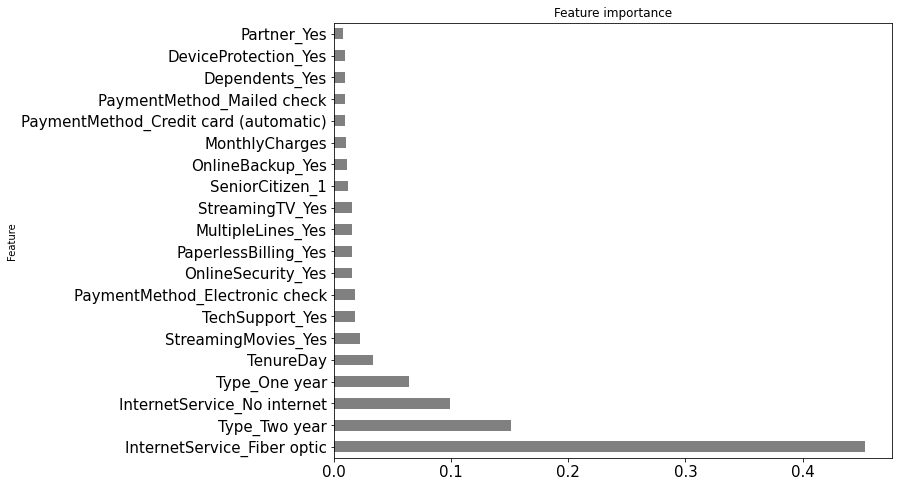

In [46]:
plot_feature_importances(best_model_XGB)

В дополнение построим график ROC-кривой и confusion_matrix

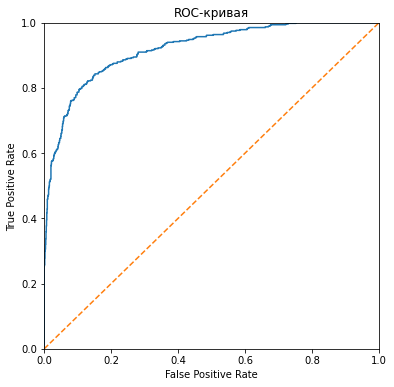

In [47]:
probabilities_one_valid = best_model_XGB.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid) 

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

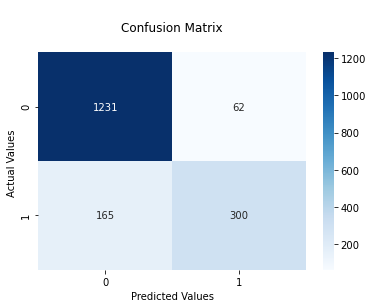

In [48]:
cf_matrix = confusion_matrix(y_test, best_model_XGB.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="")

ax.set_title('\nConfusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()

## Выводы

В результате выполнения данного проекта были построены модели для прогнозирования оттока клиентов телеком компании. Для этого были проведены разведочный и исследовательский анализ исторических данных о некоторых клиентах, об их тарифах и договорах. Различными методами, с подбором гиперпараметров, были обучены модели машинного обучения и протестирована их работа. На подготовленных данных все модели показали достаточно высокие результаты. Анализ метрик моделей показал, что если важны метрики ROC-AUC и Accuracy, то наилучшие результаты показывает модель XGBClassifier. На тестовой выборке ее результаты ROC-AUC=0.919, Accuracy=0.87. Модель также демонстриует, в сравнении с другими, высокую точность Precision=0.829. Если бизнесу важен показатель полноты (Recall), то CatBoostClassifier дает самое высокое значение этой метрики - 0.822.

Результаты финальных тестов моеделей представлены в таблице ниже:

In [49]:
display(model_comparison)

,Алгоритм,ROC-AUC (тест),Accuracy (тест),Precision (тест),Recall (тест)
0,LGBMClassifier_upsampled,0.908,0.87,0.767,0.720
1,LGBMClassifier,0.911,0.85,0.691,0.766
2,LogisticRegression,0.850,0.75,0.517,0.800
3,CatBoostClassifier,0.909,0.83,0.643,0.822
4,XGBClassifier,0.919,0.87,0.829,0.645
5,RandomForestClassifier,0.863,0.80,0.595,0.755
